In [1]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

Load forcing.


In [2]:
time_start, time_end = "1998-01-01", "2022-01-01"

data = xr.open_dataset("1_data_processing/1_1_Forcing/products/all_stations_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("1_data_processing/1_1_Forcing/products/all_stations_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [3]:
data

<xarray.Dataset> Size: 13MB
Dimensions:              (latitude: 3, longitude: 3, time: 8767, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 24B 22.75 31.6 50.0
  * longitude            (longitude) float64 24B -158.0 -150.0 -64.2
  * time                 (time) datetime64[ns] 70kB 1998-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 2MB 23.52...
    U                    (latitude, longitude, time, depth) float64 2MB 0.016...
    V                    (latitude, longitude, time, depth) float64 2MB -0.07...
    mnkc_epi             (latitude, longitude, time) float64 631kB 0.269 ... nan
    mnkc_hmlmeso         (latitude, longitude, time) float64 631kB 0.7915 ......
    mnkc_lmeso           (latitude, longitude, time) float64 631kB 2.173 ... nan
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 631kB 0.4889 ......
    mnkc_umeso           (latitude, longitude, time) float64 631kB 0.4931 ......
    npp                  (latitude, longitude, time) float64 631kB 315.7 ... nan
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 2MB 117.3...
    zeu                  (latitude, longitude, time) float64 631kB 78.19 ... nan
    zooc                 (latitude, longitude, time) float64 631kB 0.2896 ......

In [4]:
cafe_npp

<xarray.Dataset> Size: 701kB
Dimensions:    (time: 8767, latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) float64 24B 22.75 31.6 50.0
  * longitude  (longitude) float64 24B -158.0 -150.0 -64.2
  * time       (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2022-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 631kB 306.4 nan ... nan nan
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

Load observations.

First I multiply the observations by the average epipelagic layer depth (150m) to have a biomass in m2 rather than m3.


In [5]:
def update_layer(data: xr.DataArray, epipelagic_size):
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = 150 * pint.application_registry("meter")

obs_bats = xr.open_dataset("1_data_processing/1_1_Forcing/products/Bats_obs.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size)
obs_bats = Observation(obs_bats)

obs_hot = xr.open_dataset("1_data_processing/1_1_Forcing/products/Hot_obs.zarr", engine="zarr")
obs_hot = update_layer(obs_hot, epipelagic_size)
obs_hot = Observation(obs_hot)

obs_papa = xr.open_dataset("1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size)
obs_papa = Observation(obs_papa)

observations = [obs_bats, obs_hot, obs_papa]

Create structure for SeapoPym simulation.


In [6]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-05 10:57:58,586 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Setup the cost function.


In [ ]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 100),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 100),
    ),
]

In [8]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [9]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=2,
    POP_SIZE=5,
    cost_function_weight=(-(1 / 3), -(1 / 3), -(1 / 3)),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [10]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [11]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [12]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50760,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50773,Total threads: 2
Dashboard: http://127.0.0.1:50775/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50763,


And execute the process.


In [13]:
viewer = genetic_algo.optimize()

########## [[0.2463431275372821, 44.521792120415185, 0.9936693466445101, 0.7406843114454543], [0.3581290814565719, 83.23828064328359, 0.82320608341513, 0.5997681627217606], [0.18600884611745616, 58.71898018245836, 0.6601107674888236, 0.30081752292002967], [0.5229772707931629, 75.14205107131902, 0.7626432742867472, 0.7161817738179785], [0.08768510843065837, 17.326485096892043, 0.8017098363843532, 0.36612319620476713]]


2024-12-05 10:58:00,301 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:00,302 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:00,303 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:00,303 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:00,308 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:00,310 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:00,311 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-05 10:58:00,312 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-05 10:58:00,319 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:00,321 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:00,329 :: Seapodym ::  DEBU

########## [[0.18600884611745616, 83.23828064328359, 0.6601107674888236, 0.30081752292002967], [0.3581290814565719, 58.71898018245836, 0.82320608341513, 0.5997681627217606]]


2024-12-05 10:58:04,327 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:04,328 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 10:58:04,329 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:04,329 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 10:58:04,335 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-05 10:58:04,335 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-05 10:58:04,368 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-05 10:58:04,368 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-05 10:58:04,393 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-12-05 10:58:04,394 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primar

########## [[0.3581290814565719, 83.23828064328359, 0.82320608341513, 0.5997681627217606], [0.5084151082732604, 83.23828064328359, 0.82320608341513, 0.5997681627217606], [0.3581290814565719, 58.71898018245836, 0.6601107674888236, 0.5997681627217606], [0.18600884611745616, 83.23828064328359, 0.82320608341513, 0.30081752292002967]]


2024-12-05 10:58:04,871 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-05 10:58:04,871 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-05 10:58:04,876 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-05 10:58:04,894 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-05 10:58:04,895 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-05 10:58:04,898 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-05 10:58:04,905 :: Seapodym ::  DEBUG ::
|	Direct computation for _production_helper.

2024-12-05 10:58:04,905 :: Seapodym ::  DEBUG ::
|	Direct computation for _production_helper.

2024-12-05 10:58:04,909 :: Seapodym ::  DEBUG ::
|	Direct computation for _production_helper.

2024-12-05 10:58:05,099 :: Seapodym ::  DEBUG ::
|	Direct computation for _biomass_helper.

2024-12-05 10:58:05,100 :: Seapodym ::  D

Finaly here is the result :


In [14]:
viewer.stats

,mean,std,min,max,valid,generation_gap
generation,,,,,,
0,0.392212,0.085581,0.312623,0.479431,4,0.00
1,0.368234,0.076148,0.312623,0.451650,5,0.60
2,0.347380,0.069514,0.312623,0.451650,4,0.25


In [15]:
viewer.logbook

D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.246343   
                               1                          0.358129   
                               2                          0.186009   
                               3                          0.522977   
                               4                          0.087685   
1          False               2                          0.186009   
                               3                          0.358129   
           True                0                          0.186009   
                               1                          0.358129   
                               4                          0.358129   
2          False               0                          0.358129   
                               1                          0.508415   
                               2                          0.358129   
                               3                          0.186009   
           True                4                          0.358129   

                                           D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                     44.521792   
                               1                     83.238281   
                               2                     58.718980   
                               3                     75.142051   
                               4                     17.326485   
1          False               2                     83.238281   
                               3                     58.718980   
           True                0                     58.718980   
                               1                     83.238281   
                               4                     83.238281   
2          False               0                     83.238281   
                               1                     83.238281   
                               2                     58.718980   
                               3                     83.238281   
           True                4                     83.238281   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.993669   
                               1                       0.823206   
                               2                       0.660111   
                               3                       0.762643   
                               4                       0.801710   
1          False               2                       0.660111   
                               3                       0.823206   
           True                0                       0.660111   
                               1                       0.823206   
                               4                       0.823206   
2          False               0                       0.823206   
                               1                       0.823206   
                               2                       0.660111   
                               3                       0.823206   
           True                4                       0.823206   

                                           D2N1_energy_coefficient   fitness  
generation previous_generation individual                                     
0          False               0                          0.740684  0.325145  
                               1                          0.599768  0.312623  
                               2                          0.300818  0.451650  
                               3                          0.716182       inf  
                               4                          0.366123  0.479431  
1          False               2    

In [16]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_inv_lambda_max  \
generation individual                                                 
0          1                          0.358129            83.238281   
1          3                          0.358129            58.718980   
2          0                          0.358129            83.238281   
           2                          0.358129            58.718980   
0          0                          0.246343            44.521792   
           2                          0.186009            58.718980   
1          2                          0.186009            83.238281   
2          3                          0.186009            83.238281   
0          4                          0.087685            17.326485   

                       D1N1_inv_lambda_rate  D2N1_energy_coefficient   fitness  
generation individual                                                           
0          1                       0.823206                 0.599768  0.312623  
1          3                       0.823206                 0.599768  0.312623  
2          0                       0.823206                 0.599768  0.312623  
           2                       0.660111                 0.599768  0.312623  
0          0                       0.993669                 0.740684  0.325145  
           2                       0.660111                 0.300818  0.451650  
1          2                       0.660111                 0.300818  0.451650  
2          3                       0.823206                 0.300818  0.451650  
0          4                       0.801710                 0.366123  0.479431

In [17]:
viewer.fitness_evolution()

In [18]:
viewer.box_plot(3)

In [21]:
fig = viewer.parallel_coordinates(4000)
fig.update_layout(width=1000, height=700)

In [27]:
from seapopym_optimization import wrapper

best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])

model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

2024-12-05 11:02:01,705 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-05 11:02:01,708 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-05 11:02:01,720 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-05 11:02:01,758 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-05 11:02:01,787 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-12-05 11:02:01,794 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-12-05 11:02:01,795 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-12-05 11:02:01,807 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-05 11:02:01,830 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-05 11:02:01,840 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



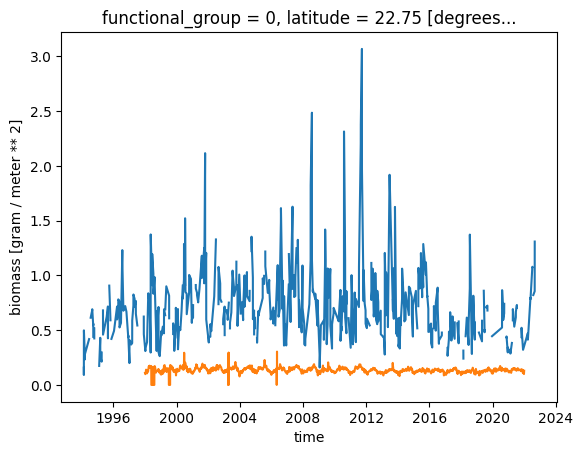

In [28]:
obs_hot.observation.day.pint.quantify().pint.to("g/m2").plot()
biomass_print.sel(latitude=22.75, longitude=-158, functional_group=0).pint.quantify().pint.to("g/m2").plot()